In [9]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import time
import h5py
import kerastuner as kt
import os
import sys
import pathlib
import csv

In [10]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [11]:
N_channels = 40
data_path = os.getcwd()

In [12]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [13]:
def load_TL_model(model_path):
    hypermodel = keras.models.load_model(model_path)
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-06), name='TL_Dense'))

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

In [14]:
# EDFA Networks

In [8]:
test_data_numbers = [200, 400, 800, 1200, 1600, 2000, 2400]
timings = []
def TL_network_test(number):
    TL_model_results = []
    for i in test_data_numbers:
        model = load_TL_model('Tuned_ANN_model.h5')
        file_path = (f'{data_path}/Data/TL_Data_EDFA/network{number}_{i}.csv')
        X_scale, Y_scale = processing_data(N_channels, file_path)
        file_path = (f'{data_path}/Data/TL_Data_EDFA/network{number}_5000_TEST.csv')
        X_test, Y_test = processing_data(N_channels, file_path)
        print(X_scale.shape, Y_scale.shape, X_test.shape, Y_test.shape)
        start_time = time.time()
        # new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
        new_hist = model.fit(X_scale, Y_scale, validation_split=0.2, epochs=150, shuffle=True, verbose=0)
        training_time = time.time() - start_time
        timings.append(training_time)
        # evaluating transfer-learned model
        eval_result = model.evaluate(X_test, Y_test, verbose=0)[1]
        # evaluating OLD model with new data
        # hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
        TL_model_results.append(eval_result)
    return TL_model_results
TL_model_results_N1 = TL_network_test('1')
TL_model_results_N2 = TL_network_test('2')

(200, 41) (200, 40) (5000, 41) (5000, 40)
(400, 41) (400, 40) (5000, 41) (5000, 40)
(800, 41) (800, 40) (5000, 41) (5000, 40)
(1200, 41) (1200, 40) (5000, 41) (5000, 40)
(1600, 41) (1600, 40) (5000, 41) (5000, 40)
(2000, 41) (2000, 40) (5000, 41) (5000, 40)
(2400, 41) (2400, 40) (5000, 41) (5000, 40)
(200, 41) (200, 40) (5000, 41) (5000, 40)
(400, 41) (400, 40) (5000, 41) (5000, 40)
(800, 41) (800, 40) (5000, 41) (5000, 40)
(1200, 41) (1200, 40) (5000, 41) (5000, 40)
(1600, 41) (1600, 40) (5000, 41) (5000, 40)
(2000, 41) (2000, 40) (5000, 41) (5000, 40)
(2400, 41) (2400, 40) (5000, 41) (5000, 40)


In [4]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

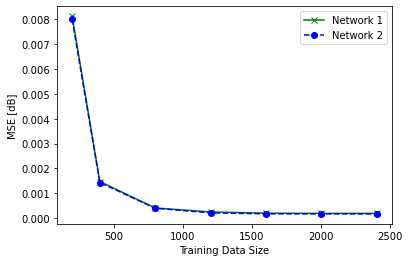

In [11]:
plt.plot(test_data_numbers, TL_model_results_N1, label='Network 1', marker='x', color=colors['green'])
plt.plot(test_data_numbers, TL_model_results_N2, label='Network 2', marker='o', color=colors['blue'], linestyle='--')
plt.ylabel('MSE [dB]')
plt.xlabel('Training Data Size')
plt.legend()
plt.savefig(f'{data_path}/Figures/transfer_learning_EDFA_results.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Raman Networks - GGN model

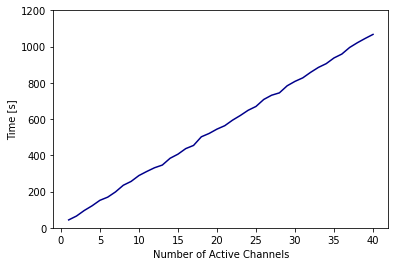

In [5]:
# Timings pasted from terminal
timings = [37.53791856765747, 44.47045350074768, 63.32831048965454, 63.37506365776062, 92.2624683380127, 101.36327958106995, 127.2022910118103, 128.8183991909027, 146.18886709213257, 154.03905510902405, 169.45223116874695, 180.0242350101471, 202.27941131591797, 186.95078349113464, 231.9132387638092, 235.80909180641174, 238.02216506004333, 262.52415585517883, 295.4653024673462, 282.79807806015015, 314.0984613895416, 300.1329183578491, 318.3239064216614, 342.6468069553375, 341.85795998573303, 338.9036498069763, 396.2428140640259, 380.6560711860657, 409.18574833869934, 410.63210701942444, 428.5700755119324, 446.07497000694275, 464.18149399757385, 476.0715534687042, 509.7240798473358, 502.15772557258606, 526.4843437671661, 531.1146490573883, 546.1816582679749, 530.184743642807, 564.6300182342529, 543.1818542480469, 604.5711410045624, 597.9672174453735, 636.0374624729156, 606.8063626289368, 656.8883156776428, 630.4283859729767, 693.5758180618286, 684.148622751236, 699.0965142250061, 698.5889072418213, 733.7673182487488, 728.1497437953949, 747.5423681735992, 732.1805770397186, 795.8408675193787, 784.3137204647064, 823.3255343437195, 806.6421318054199, 812.1924839019775, 831.0661885738373, 853.6679453849792, 874.6142926216125, 880.324205160141, 883.985169172287, 902.1533312797546, 906.7828867435455, 939.4710423946381, 958.7142722606659, 958.7406995296478, 965.4762909412384, 988.1618983745575, 1001.0708174705505, 1020.485728263855, 1013.999463558197, 1056.151177406311, 1037.401254415512, 1064.9133727550507, 1061.2183439731598]
timings2 = [45.44373607635498, 46.39151430130005, 71.88638520240784, 60.848305463790894, 90.2727882862091, 98.38968420028687, 126.34571504592896, 103.31419968605042, 153.83978462219238, 152.44257521629333, 171.29617476463318, 155.64072728157043, 201.69269347190857, 201.33199286460876, 235.09215092658997, 236.43923497200012, 259.33132672309875, 263.961457490921, 282.86732482910156, 292.2573585510254, 306.2440962791443, 322.33714842796326, 323.8816931247711, 340.61911964416504, 335.95193123817444, 368.26044058799744, 364.89508628845215, 393.548157453537, 390.94132566452026, 414.20369696617126, 433.55249428749084, 439.87579250335693, 435.1022753715515, 442.87834310531616, 496.4673607349396, 500.65900468826294, 507.62135100364685, 517.7434628009796, 543.3064279556274, 558.5317633152008, 574.6485662460327, 571.3963468074799, 594.0323643684387, 579.8316121101379, 613.002302646637, 624.0610625743866, 670.3513743877411, 636.9688713550568, 654.8742032051086, 646.1440205574036, 703.7103109359741, 732.020813703537, 725.0013020038605, 739.5422172546387, 752.2881071567535, 746.7799875736237, 771.2034537792206, 783.8148059844971, 791.6866688728333, 810.8507723808289, 839.7172744274139, 827.2433030605316, 852.0638256072998, 851.3664450645447, 890.7072277069092, 885.4374439716339, 918.0034379959106, 896.654248714447, 918.100900888443, 933.5194518566132, 946.6818528175354, 964.0156850814819, 992.3744978904724, 999.0277001857758, 1031.5241856575012, 1020.2360715866089, 1044.5985527038574, 1042.588624715805, 1061.7617621421814, 1081.3993773460388]
timings_ave = []
for i in range(0,79,2):
    av = (timings[i] + timings[i+1] + timings2[i] + timings2[i+1])/4
    timings_ave.append(av)
active_channel_number = [i for i in range(1, 41)]
plt.plot(active_channel_number, timings_ave, color=colors['darkblue'])
plt.ylim([0, 1200])
plt.ylabel('Time [s]')
plt.xlabel('Number of Active Channels')
plt.savefig('/Users/jackkelly/Desktop/Building_Model/Figures/raman_data_generation_timings.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

In [11]:
def createLabels(channel_no):
    labels = ['launch_power_dbm']
    for i in range(1, channel_no+1):
        labels.append('Status_Ch' + str(i))
    for i in range(1, channel_no+1):
        labels.append('snr_Ch' + str(i))
    return labels
def instantiateWriteFile(file_path):
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
def add_row_of_data(file_path, list_of_elem):
    with open(file_path, 'a+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(list_of_elem)

In [66]:
labels = createLabels(40)

In [74]:
instantiateWriteFile(f'{data_path}/Data/TL_Data_Raman/Raman_data_All.csv')
for i in range(1, 9):
    file_path = f'{data_path}/Data/TL_Data_Raman/Raman_data{i}.csv'
    df = pd.read_csv(file_path)
    dataset = df.values
    for j in dataset:
        add_row_of_data(f'{data_path}/Data/TL_Data_Raman/Raman_data_All.csv', j)

In [75]:
test_data_numbers_GGN = [200, 320, 560]
timings = []
def TL_network_test_Raman_GGN():
    TL_Raman_model_results_GGN = []
    for i in test_data_numbers_GGN:
        model = load_TL_model('Tuned_ANN_model.h5')
        file_path = (f'{data_path}/Data/TL_Data_Raman/Raman_data_All.csv')
        X_scale, Y_scale = processing_data(N_channels, file_path)
        X_scale = X_scale[:i]
        Y_scale = Y_scale[:i]
#         file_path = (f'{data_path}/Data/TL_Data_EDFA/network{number}_5000_TEST.csv')
#         X_test, Y_test = processing_data(N_channels, file_path)
#         print(X_scale.shape, Y_scale.shape, X_test.shape, Y_test.shape)
        print(X_scale.shape, Y_scale.shape)
        start_time = time.time()
        # new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
        new_hist = model.fit(X_scale, Y_scale, validation_split=0.2, epochs=500, shuffle=True, verbose=1)
        training_time = time.time() - start_time
        timings.append(training_time)
        # evaluating transfer-learned model
        eval_result = model.evaluate(X_scale, Y_scale, verbose=0)[1]
        # evaluating OLD model with new data
        # hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
        TL_Raman_model_results_GGN.append(eval_result)
    return TL_Raman_model_results_GGN
TL_Raman_model_results_GGN = TL_network_test_Raman_GGN()

(200, 41) (200, 40)
Epoch 1/500
5/5 [==============================] - 0s 24ms/step - loss: 0.3821 - mean_squared_error: 0.3816 - val_loss: 0.3678 - val_mean_squared_error: 0.3672
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3462 - mean_squared_error: 0.3457 - val_loss: 0.3371 - val_mean_squared_error: 0.3365
Epoch 3/500
5/5 [==============================] - 0s 6ms/step - loss: 0.3219 - mean_squared_error: 0.3213 - val_loss: 0.3202 - val_mean_squared_error: 0.3196
Epoch 4/500
5/5 [==============================] - 0s 5ms/step - loss: 0.3015 - mean_squared_error: 0.3009 - val_loss: 0.3087 - val_mean_squared_error: 0.3081
Epoch 5/500
5/5 [==============================] - 0s 5ms/step - loss: 0.2822 - mean_squared_error: 0.2817 - val_loss: 0.2983 - val_mean_squared_error: 0.2977
Epoch 6/500
5/5 [==============================] - 0s 4ms/step - loss: 0.2717 - mean_squared_error: 0.2711 - val_loss: 0.2874 - val_mean_squared_error: 0.2868
Epoch 7/500
5/5 [========

5/5 [==============================] - 0s 4ms/step - loss: 0.0582 - mean_squared_error: 0.0577 - val_loss: 0.0914 - val_mean_squared_error: 0.0909
Epoch 104/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0581 - mean_squared_error: 0.0575 - val_loss: 0.0893 - val_mean_squared_error: 0.0887
Epoch 105/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0571 - mean_squared_error: 0.0565 - val_loss: 0.0906 - val_mean_squared_error: 0.0900
Epoch 106/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0564 - mean_squared_error: 0.0558 - val_loss: 0.0886 - val_mean_squared_error: 0.0881
Epoch 107/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0554 - mean_squared_error: 0.0548 - val_loss: 0.0868 - val_mean_squared_error: 0.0862
Epoch 108/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0549 - mean_squared_error: 0.0543 - val_loss: 0.0870 - val_mean_squared_error: 0.0864
Epoch 109/500
5/5 [=============================

Epoch 154/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0348 - mean_squared_error: 0.0342 - val_loss: 0.0601 - val_mean_squared_error: 0.0595
Epoch 155/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0344 - mean_squared_error: 0.0338 - val_loss: 0.0594 - val_mean_squared_error: 0.0588
Epoch 156/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0340 - mean_squared_error: 0.0334 - val_loss: 0.0595 - val_mean_squared_error: 0.0590
Epoch 157/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0338 - mean_squared_error: 0.0332 - val_loss: 0.0585 - val_mean_squared_error: 0.0579
Epoch 158/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0336 - mean_squared_error: 0.0330 - val_loss: 0.0587 - val_mean_squared_error: 0.0581
Epoch 159/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0333 - mean_squared_error: 0.0328 - val_loss: 0.0579 - val_mean_squared_error: 0.0574
Epoch 160/500
5/5 [===============

Epoch 205/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0250 - mean_squared_error: 0.0244 - val_loss: 0.0445 - val_mean_squared_error: 0.0439
Epoch 206/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0249 - mean_squared_error: 0.0244 - val_loss: 0.0440 - val_mean_squared_error: 0.0434
Epoch 207/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0250 - mean_squared_error: 0.0244 - val_loss: 0.0442 - val_mean_squared_error: 0.0436
Epoch 208/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0247 - mean_squared_error: 0.0241 - val_loss: 0.0434 - val_mean_squared_error: 0.0428
Epoch 209/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0246 - mean_squared_error: 0.0240 - val_loss: 0.0434 - val_mean_squared_error: 0.0428
Epoch 210/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0246 - mean_squared_error: 0.0241 - val_loss: 0.0439 - val_mean_squared_error: 0.0433
Epoch 211/500
5/5 [===============

Epoch 256/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0206 - mean_squared_error: 0.0200 - val_loss: 0.0353 - val_mean_squared_error: 0.0348
Epoch 257/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0206 - mean_squared_error: 0.0200 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 258/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0205 - mean_squared_error: 0.0199 - val_loss: 0.0357 - val_mean_squared_error: 0.0351
Epoch 259/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0205 - mean_squared_error: 0.0199 - val_loss: 0.0351 - val_mean_squared_error: 0.0345
Epoch 260/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0204 - mean_squared_error: 0.0198 - val_loss: 0.0352 - val_mean_squared_error: 0.0346
Epoch 261/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0203 - mean_squared_error: 0.0197 - val_loss: 0.0353 - val_mean_squared_error: 0.0347
Epoch 262/500
5/5 [===============

Epoch 307/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0184 - mean_squared_error: 0.0178 - val_loss: 0.0305 - val_mean_squared_error: 0.0299
Epoch 308/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0183 - mean_squared_error: 0.0177 - val_loss: 0.0305 - val_mean_squared_error: 0.0299
Epoch 309/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0183 - mean_squared_error: 0.0177 - val_loss: 0.0305 - val_mean_squared_error: 0.0299
Epoch 310/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0183 - mean_squared_error: 0.0177 - val_loss: 0.0302 - val_mean_squared_error: 0.0296
Epoch 311/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0182 - mean_squared_error: 0.0176 - val_loss: 0.0303 - val_mean_squared_error: 0.0297
Epoch 312/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0182 - mean_squared_error: 0.0176 - val_loss: 0.0302 - val_mean_squared_error: 0.0296
Epoch 313/500
5/5 [===============

Epoch 358/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0171 - mean_squared_error: 0.0165 - val_loss: 0.0272 - val_mean_squared_error: 0.0266
Epoch 359/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0171 - mean_squared_error: 0.0165 - val_loss: 0.0270 - val_mean_squared_error: 0.0264
Epoch 360/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0170 - mean_squared_error: 0.0164 - val_loss: 0.0272 - val_mean_squared_error: 0.0266
Epoch 361/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0170 - mean_squared_error: 0.0164 - val_loss: 0.0271 - val_mean_squared_error: 0.0265
Epoch 362/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0170 - mean_squared_error: 0.0164 - val_loss: 0.0267 - val_mean_squared_error: 0.0261
Epoch 363/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0169 - mean_squared_error: 0.0163 - val_loss: 0.0269 - val_mean_squared_error: 0.0263
Epoch 364/500
5/5 [===============

Epoch 409/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - mean_squared_error: 0.0156 - val_loss: 0.0247 - val_mean_squared_error: 0.0241
Epoch 410/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - mean_squared_error: 0.0156 - val_loss: 0.0247 - val_mean_squared_error: 0.0241
Epoch 411/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - mean_squared_error: 0.0156 - val_loss: 0.0247 - val_mean_squared_error: 0.0241
Epoch 412/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - mean_squared_error: 0.0156 - val_loss: 0.0247 - val_mean_squared_error: 0.0241
Epoch 413/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - mean_squared_error: 0.0156 - val_loss: 0.0245 - val_mean_squared_error: 0.0239
Epoch 414/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0161 - mean_squared_error: 0.0155 - val_loss: 0.0246 - val_mean_squared_error: 0.0240
Epoch 415/500
5/5 [===============

Epoch 460/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0157 - mean_squared_error: 0.0150 - val_loss: 0.0230 - val_mean_squared_error: 0.0224
Epoch 461/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0150 - val_loss: 0.0230 - val_mean_squared_error: 0.0224
Epoch 462/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0150 - val_loss: 0.0230 - val_mean_squared_error: 0.0223
Epoch 463/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0150 - val_loss: 0.0229 - val_mean_squared_error: 0.0222
Epoch 464/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0149 - val_loss: 0.0229 - val_mean_squared_error: 0.0223
Epoch 465/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - mean_squared_error: 0.0150 - val_loss: 0.0228 - val_mean_squared_error: 0.0222
Epoch 466/500
5/5 [===============

Epoch 11/500
8/8 [==============================] - 0s 3ms/step - loss: 0.2073 - mean_squared_error: 0.2067 - val_loss: 0.2043 - val_mean_squared_error: 0.2037
Epoch 12/500
8/8 [==============================] - 0s 2ms/step - loss: 0.2008 - mean_squared_error: 0.2002 - val_loss: 0.1992 - val_mean_squared_error: 0.1986
Epoch 13/500
8/8 [==============================] - 0s 3ms/step - loss: 0.1973 - mean_squared_error: 0.1967 - val_loss: 0.1964 - val_mean_squared_error: 0.1958
Epoch 14/500
8/8 [==============================] - 0s 3ms/step - loss: 0.1929 - mean_squared_error: 0.1923 - val_loss: 0.1913 - val_mean_squared_error: 0.1908
Epoch 15/500
8/8 [==============================] - 0s 2ms/step - loss: 0.1879 - mean_squared_error: 0.1873 - val_loss: 0.1894 - val_mean_squared_error: 0.1888
Epoch 16/500
8/8 [==============================] - 0s 2ms/step - loss: 0.1845 - mean_squared_error: 0.1839 - val_loss: 0.1859 - val_mean_squared_error: 0.1853
Epoch 17/500
8/8 [======================

8/8 [==============================] - 0s 3ms/step - loss: 0.0256 - mean_squared_error: 0.0250 - val_loss: 0.0363 - val_mean_squared_error: 0.0357
Epoch 114/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0253 - mean_squared_error: 0.0247 - val_loss: 0.0361 - val_mean_squared_error: 0.0355
Epoch 115/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0251 - mean_squared_error: 0.0245 - val_loss: 0.0360 - val_mean_squared_error: 0.0354
Epoch 116/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0247 - mean_squared_error: 0.0241 - val_loss: 0.0350 - val_mean_squared_error: 0.0344
Epoch 117/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0244 - mean_squared_error: 0.0238 - val_loss: 0.0353 - val_mean_squared_error: 0.0347
Epoch 118/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0241 - mean_squared_error: 0.0235 - val_loss: 0.0346 - val_mean_squared_error: 0.0340
Epoch 119/500
8/8 [=============================

Epoch 164/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0170 - mean_squared_error: 0.0164 - val_loss: 0.0239 - val_mean_squared_error: 0.0233
Epoch 165/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0169 - mean_squared_error: 0.0163 - val_loss: 0.0237 - val_mean_squared_error: 0.0231
Epoch 166/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0167 - mean_squared_error: 0.0161 - val_loss: 0.0237 - val_mean_squared_error: 0.0231
Epoch 167/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0167 - mean_squared_error: 0.0161 - val_loss: 0.0233 - val_mean_squared_error: 0.0227
Epoch 168/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0166 - mean_squared_error: 0.0160 - val_loss: 0.0233 - val_mean_squared_error: 0.0227
Epoch 169/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0165 - mean_squared_error: 0.0159 - val_loss: 0.0232 - val_mean_squared_error: 0.0226
Epoch 170/500
8/8 [===============

Epoch 215/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0097 - mean_squared_error: 0.0091 - val_loss: 0.0138 - val_mean_squared_error: 0.0132
Epoch 216/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0094 - mean_squared_error: 0.0088 - val_loss: 0.0136 - val_mean_squared_error: 0.0130
Epoch 217/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0093 - mean_squared_error: 0.0087 - val_loss: 0.0134 - val_mean_squared_error: 0.0128
Epoch 218/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0091 - mean_squared_error: 0.0086 - val_loss: 0.0136 - val_mean_squared_error: 0.0130
Epoch 219/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0090 - mean_squared_error: 0.0084 - val_loss: 0.0128 - val_mean_squared_error: 0.0122
Epoch 220/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_squared_error: 0.0082 - val_loss: 0.0133 - val_mean_squared_error: 0.0127
Epoch 221/500
8/8 [===============

Epoch 266/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0051 - val_loss: 0.0083 - val_mean_squared_error: 0.0077
Epoch 267/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0051 - val_loss: 0.0085 - val_mean_squared_error: 0.0079
Epoch 268/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0056 - mean_squared_error: 0.0050 - val_loss: 0.0082 - val_mean_squared_error: 0.0076
Epoch 269/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0056 - mean_squared_error: 0.0050 - val_loss: 0.0082 - val_mean_squared_error: 0.0076
Epoch 270/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0049 - val_loss: 0.0080 - val_mean_squared_error: 0.0074
Epoch 271/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0049 - val_loss: 0.0083 - val_mean_squared_error: 0.0077
Epoch 272/500
8/8 [===============

Epoch 317/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0038 - val_loss: 0.0065 - val_mean_squared_error: 0.0058
Epoch 318/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0038 - val_loss: 0.0065 - val_mean_squared_error: 0.0059
Epoch 319/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0039 - val_loss: 0.0064 - val_mean_squared_error: 0.0058
Epoch 320/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0038 - val_loss: 0.0064 - val_mean_squared_error: 0.0058
Epoch 321/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0038 - val_loss: 0.0065 - val_mean_squared_error: 0.0059
Epoch 322/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0038 - val_loss: 0.0063 - val_mean_squared_error: 0.0057
Epoch 323/500
8/8 [===============

Epoch 368/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0033 - val_loss: 0.0054 - val_mean_squared_error: 0.0048
Epoch 369/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0033 - val_loss: 0.0055 - val_mean_squared_error: 0.0049
Epoch 370/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0033 - val_loss: 0.0054 - val_mean_squared_error: 0.0048
Epoch 371/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0032 - val_loss: 0.0056 - val_mean_squared_error: 0.0050
Epoch 372/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0032 - val_loss: 0.0053 - val_mean_squared_error: 0.0047
Epoch 373/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0032 - val_loss: 0.0056 - val_mean_squared_error: 0.0050
Epoch 374/500
8/8 [===============

Epoch 419/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0050 - val_mean_squared_error: 0.0043
Epoch 420/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0048 - val_mean_squared_error: 0.0042
Epoch 421/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0049 - val_mean_squared_error: 0.0043
Epoch 422/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0046 - val_mean_squared_error: 0.0040
Epoch 423/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0050 - val_mean_squared_error: 0.0044
Epoch 424/500
8/8 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0029 - val_loss: 0.0046 - val_mean_squared_error: 0.0040
Epoch 425/500
8/8 [===============

Epoch 470/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 471/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0045 - val_mean_squared_error: 0.0039
Epoch 472/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 473/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0026 - val_loss: 0.0044 - val_mean_squared_error: 0.0037
Epoch 474/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0027 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 475/500
8/8 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0027 - val_loss: 0.0045 - val_mean_squared_error: 0.0038
Epoch 476/500
8/8 [===============

Epoch 21/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1358 - mean_squared_error: 0.1352 - val_loss: 0.1341 - val_mean_squared_error: 0.1335
Epoch 22/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1310 - mean_squared_error: 0.1304 - val_loss: 0.1294 - val_mean_squared_error: 0.1288
Epoch 23/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1279 - mean_squared_error: 0.1273 - val_loss: 0.1255 - val_mean_squared_error: 0.1249
Epoch 24/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1239 - mean_squared_error: 0.1233 - val_loss: 0.1230 - val_mean_squared_error: 0.1224
Epoch 25/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1210 - mean_squared_error: 0.1204 - val_loss: 0.1212 - val_mean_squared_error: 0.1207
Epoch 26/500
14/14 [==============================] - 0s 2ms/step - loss: 0.1173 - mean_squared_error: 0.1167 - val_loss: 0.1177 - val_mean_squared_error: 0.1171
Epoch 27/500
14/14 [========

14/14 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0066 - val_loss: 0.0089 - val_mean_squared_error: 0.0083
Epoch 122/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0065 - val_loss: 0.0092 - val_mean_squared_error: 0.0086
Epoch 123/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0071 - mean_squared_error: 0.0065 - val_loss: 0.0088 - val_mean_squared_error: 0.0082
Epoch 124/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0070 - mean_squared_error: 0.0064 - val_loss: 0.0088 - val_mean_squared_error: 0.0082
Epoch 125/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0069 - mean_squared_error: 0.0063 - val_loss: 0.0090 - val_mean_squared_error: 0.0084
Epoch 126/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0068 - mean_squared_error: 0.0062 - val_loss: 0.0086 - val_mean_squared_error: 0.0080
Epoch 127/500
14/14 [===============

14/14 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0046 - val_mean_squared_error: 0.0040
Epoch 222/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0030 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 223/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0030 - val_loss: 0.0045 - val_mean_squared_error: 0.0039
Epoch 224/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 225/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 226/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0030 - val_loss: 0.0044 - val_mean_squared_error: 0.0038
Epoch 227/500
14/14 [===============

14/14 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0033 - val_mean_squared_error: 0.0027
Epoch 322/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0034 - val_mean_squared_error: 0.0027
Epoch 323/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0033 - val_mean_squared_error: 0.0027
Epoch 324/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0034 - val_mean_squared_error: 0.0027
Epoch 325/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0033 - val_mean_squared_error: 0.0027
Epoch 326/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0034 - val_mean_squared_error: 0.0028
Epoch 327/500
14/14 [===============

14/14 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0019 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 422/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0019 - val_loss: 0.0030 - val_mean_squared_error: 0.0024
Epoch 423/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0019 - val_loss: 0.0031 - val_mean_squared_error: 0.0025
Epoch 424/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0031 - val_mean_squared_error: 0.0025
Epoch 425/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0019 - val_loss: 0.0030 - val_mean_squared_error: 0.0023
Epoch 426/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0019 - val_loss: 0.0030 - val_mean_squared_error: 0.0024
Epoch 427/500
14/14 [===============

# Raman Networks - GN model

In [76]:
instantiateWriteFile(f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data_All.csv')
for i in range(1, 5):
    file_path = f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data{i}.csv'
    df = pd.read_csv(file_path)
    dataset = df.values
    print(dataset.shape)
    for j in dataset:
        add_row_of_data(f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data_All.csv', j)

(800, 81)
(800, 81)
(400, 81)
(800, 81)


In [77]:
file_path = f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data_All.csv'
df = pd.read_csv(file_path)
dataset = df.values
dataset.shape

(2800, 81)

In [15]:
test_data_numbers_GN = [200, 400, 800, 1200, 1600, 2000, 2400]
timings = []
def TL_network_test_Raman_GN():
    TL_Raman_model_results_GN = []
    for i in test_data_numbers_GN:
        model = load_TL_model('Tuned_ANN_model.h5')
        file_path = (f'{data_path}/Data/TL_Data_Raman/Raman_GN_data_All.csv')
        X_scale, Y_scale = processing_data(N_channels, file_path)
        X_scale = X_scale[:i]
        Y_scale = Y_scale[:i]
#         file_path = (f'{data_path}/Data/TL_Data_EDFA/network{number}_5000_TEST.csv')
#         X_test, Y_test = processing_data(N_channels, file_path)
#         print(X_scale.shape, Y_scale.shape, X_test.shape, Y_test.shape)
        print(X_scale.shape, Y_scale.shape)
        start_time = time.time()
        # new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
        new_hist = model.fit(X_scale, Y_scale, validation_split=0.2, epochs=500, shuffle=True, verbose=1)
        training_time = time.time() - start_time
        timings.append(training_time)
        # evaluating transfer-learned model
        eval_result = model.evaluate(X_scale[i:2800], Y_scale[i:2800], verbose=0)[1]
        # evaluating OLD model with new data
        # hypermodel_result = hypermodel.evaluate(X_test, Y_test, verbose=0)[1]
        TL_Raman_model_results_GN.append(eval_result)
    print(timings)
    return TL_Raman_model_results_GN
TL_Raman_model_results_GN = TL_network_test_Raman_GN()

(200, 41) (200, 40)
Epoch 1/500
5/5 [==============================] - 0s 27ms/step - loss: 0.3809 - mean_squared_error: 0.3803 - val_loss: 0.3571 - val_mean_squared_error: 0.3565
Epoch 2/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3418 - mean_squared_error: 0.3413 - val_loss: 0.3442 - val_mean_squared_error: 0.3436
Epoch 3/500
5/5 [==============================] - 0s 4ms/step - loss: 0.3219 - mean_squared_error: 0.3213 - val_loss: 0.3185 - val_mean_squared_error: 0.3179
Epoch 4/500
5/5 [==============================] - 0s 4ms/step - loss: 0.2971 - mean_squared_error: 0.2965 - val_loss: 0.3009 - val_mean_squared_error: 0.3003
Epoch 5/500
5/5 [==============================] - 0s 4ms/step - loss: 0.2873 - mean_squared_error: 0.2867 - val_loss: 0.2940 - val_mean_squared_error: 0.2934
Epoch 6/500
5/5 [==============================] - 0s 4ms/step - loss: 0.2805 - mean_squared_error: 0.2799 - val_loss: 0.2870 - val_mean_squared_error: 0.2864
Epoch 7/500
5/5 [========

5/5 [==============================] - 0s 4ms/step - loss: 0.1194 - mean_squared_error: 0.1188 - val_loss: 0.1464 - val_mean_squared_error: 0.1458
Epoch 53/500
5/5 [==============================] - 0s 4ms/step - loss: 0.1178 - mean_squared_error: 0.1173 - val_loss: 0.1458 - val_mean_squared_error: 0.1452
Epoch 54/500
5/5 [==============================] - 0s 4ms/step - loss: 0.1164 - mean_squared_error: 0.1159 - val_loss: 0.1454 - val_mean_squared_error: 0.1448
Epoch 55/500
5/5 [==============================] - 0s 4ms/step - loss: 0.1149 - mean_squared_error: 0.1143 - val_loss: 0.1433 - val_mean_squared_error: 0.1427
Epoch 56/500
5/5 [==============================] - 0s 4ms/step - loss: 0.1133 - mean_squared_error: 0.1128 - val_loss: 0.1417 - val_mean_squared_error: 0.1411
Epoch 57/500
5/5 [==============================] - 0s 4ms/step - loss: 0.1116 - mean_squared_error: 0.1110 - val_loss: 0.1410 - val_mean_squared_error: 0.1404
Epoch 58/500
5/5 [==============================] - 0

Epoch 103/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0658 - mean_squared_error: 0.0653 - val_loss: 0.0969 - val_mean_squared_error: 0.0963
Epoch 104/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0651 - mean_squared_error: 0.0645 - val_loss: 0.0961 - val_mean_squared_error: 0.0955
Epoch 105/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0646 - mean_squared_error: 0.0641 - val_loss: 0.0957 - val_mean_squared_error: 0.0951
Epoch 106/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0639 - mean_squared_error: 0.0633 - val_loss: 0.0949 - val_mean_squared_error: 0.0943
Epoch 107/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0637 - mean_squared_error: 0.0631 - val_loss: 0.0941 - val_mean_squared_error: 0.0935
Epoch 108/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0630 - mean_squared_error: 0.0624 - val_loss: 0.0937 - val_mean_squared_error: 0.0932
Epoch 109/500
5/5 [===============

Epoch 154/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0465 - mean_squared_error: 0.0459 - val_loss: 0.0727 - val_mean_squared_error: 0.0721
Epoch 155/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0462 - mean_squared_error: 0.0456 - val_loss: 0.0726 - val_mean_squared_error: 0.0720
Epoch 156/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0460 - mean_squared_error: 0.0454 - val_loss: 0.0719 - val_mean_squared_error: 0.0713
Epoch 157/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0458 - mean_squared_error: 0.0452 - val_loss: 0.0721 - val_mean_squared_error: 0.0715
Epoch 158/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0457 - mean_squared_error: 0.0451 - val_loss: 0.0715 - val_mean_squared_error: 0.0709
Epoch 159/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0454 - mean_squared_error: 0.0448 - val_loss: 0.0714 - val_mean_squared_error: 0.0708
Epoch 160/500
5/5 [===============

Epoch 205/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0307 - mean_squared_error: 0.0302 - val_loss: 0.0525 - val_mean_squared_error: 0.0519
Epoch 206/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0306 - mean_squared_error: 0.0300 - val_loss: 0.0523 - val_mean_squared_error: 0.0517
Epoch 207/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0304 - mean_squared_error: 0.0299 - val_loss: 0.0515 - val_mean_squared_error: 0.0509
Epoch 208/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0304 - mean_squared_error: 0.0298 - val_loss: 0.0512 - val_mean_squared_error: 0.0506
Epoch 209/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0303 - mean_squared_error: 0.0297 - val_loss: 0.0515 - val_mean_squared_error: 0.0509
Epoch 210/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0300 - mean_squared_error: 0.0294 - val_loss: 0.0509 - val_mean_squared_error: 0.0503
Epoch 211/500
5/5 [===============

Epoch 256/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0255 - mean_squared_error: 0.0249 - val_loss: 0.0430 - val_mean_squared_error: 0.0424
Epoch 257/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0255 - mean_squared_error: 0.0249 - val_loss: 0.0428 - val_mean_squared_error: 0.0422
Epoch 258/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0254 - mean_squared_error: 0.0248 - val_loss: 0.0427 - val_mean_squared_error: 0.0421
Epoch 259/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0254 - mean_squared_error: 0.0248 - val_loss: 0.0426 - val_mean_squared_error: 0.0421
Epoch 260/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0253 - mean_squared_error: 0.0248 - val_loss: 0.0424 - val_mean_squared_error: 0.0419
Epoch 261/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0253 - mean_squared_error: 0.0247 - val_loss: 0.0424 - val_mean_squared_error: 0.0418
Epoch 262/500
5/5 [===============

Epoch 307/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0236 - mean_squared_error: 0.0230 - val_loss: 0.0387 - val_mean_squared_error: 0.0381
Epoch 308/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0236 - mean_squared_error: 0.0230 - val_loss: 0.0385 - val_mean_squared_error: 0.0379
Epoch 309/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0236 - mean_squared_error: 0.0229 - val_loss: 0.0385 - val_mean_squared_error: 0.0379
Epoch 310/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0235 - mean_squared_error: 0.0229 - val_loss: 0.0384 - val_mean_squared_error: 0.0378
Epoch 311/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0235 - mean_squared_error: 0.0229 - val_loss: 0.0383 - val_mean_squared_error: 0.0377
Epoch 312/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0235 - mean_squared_error: 0.0229 - val_loss: 0.0382 - val_mean_squared_error: 0.0376
Epoch 313/500
5/5 [===============

Epoch 358/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0225 - mean_squared_error: 0.0219 - val_loss: 0.0358 - val_mean_squared_error: 0.0352
Epoch 359/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0225 - mean_squared_error: 0.0219 - val_loss: 0.0357 - val_mean_squared_error: 0.0351
Epoch 360/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0225 - mean_squared_error: 0.0218 - val_loss: 0.0358 - val_mean_squared_error: 0.0352
Epoch 361/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - mean_squared_error: 0.0218 - val_loss: 0.0357 - val_mean_squared_error: 0.0351
Epoch 362/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0224 - mean_squared_error: 0.0218 - val_loss: 0.0357 - val_mean_squared_error: 0.0351
Epoch 363/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0224 - mean_squared_error: 0.0218 - val_loss: 0.0356 - val_mean_squared_error: 0.0350
Epoch 364/500
5/5 [===============

Epoch 409/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0218 - mean_squared_error: 0.0212 - val_loss: 0.0340 - val_mean_squared_error: 0.0333
Epoch 410/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0218 - mean_squared_error: 0.0211 - val_loss: 0.0339 - val_mean_squared_error: 0.0333
Epoch 411/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0217 - mean_squared_error: 0.0211 - val_loss: 0.0339 - val_mean_squared_error: 0.0333
Epoch 412/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0217 - mean_squared_error: 0.0211 - val_loss: 0.0339 - val_mean_squared_error: 0.0332
Epoch 413/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0218 - mean_squared_error: 0.0211 - val_loss: 0.0338 - val_mean_squared_error: 0.0332
Epoch 414/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0217 - mean_squared_error: 0.0211 - val_loss: 0.0338 - val_mean_squared_error: 0.0332
Epoch 415/500
5/5 [===============

Epoch 460/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_squared_error: 0.0207 - val_loss: 0.0326 - val_mean_squared_error: 0.0320
Epoch 461/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_squared_error: 0.0207 - val_loss: 0.0326 - val_mean_squared_error: 0.0320
Epoch 462/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_squared_error: 0.0207 - val_loss: 0.0326 - val_mean_squared_error: 0.0320
Epoch 463/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_squared_error: 0.0207 - val_loss: 0.0325 - val_mean_squared_error: 0.0319
Epoch 464/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0213 - mean_squared_error: 0.0206 - val_loss: 0.0325 - val_mean_squared_error: 0.0319
Epoch 465/500
5/5 [==============================] - 0s 4ms/step - loss: 0.0212 - mean_squared_error: 0.0206 - val_loss: 0.0325 - val_mean_squared_error: 0.0319
Epoch 466/500
5/5 [===============

Epoch 11/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1892 - mean_squared_error: 0.1886 - val_loss: 0.1851 - val_mean_squared_error: 0.1845
Epoch 12/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1843 - mean_squared_error: 0.1837 - val_loss: 0.1810 - val_mean_squared_error: 0.1805
Epoch 13/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1792 - mean_squared_error: 0.1786 - val_loss: 0.1759 - val_mean_squared_error: 0.1754
Epoch 14/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1739 - mean_squared_error: 0.1733 - val_loss: 0.1727 - val_mean_squared_error: 0.1721
Epoch 15/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1693 - mean_squared_error: 0.1687 - val_loss: 0.1686 - val_mean_squared_error: 0.1680
Epoch 16/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1648 - mean_squared_error: 0.1642 - val_loss: 0.1647 - val_mean_squared_error: 0.1641
Epoch 17/500
10/10 [========

10/10 [==============================] - 0s 2ms/step - loss: 0.0528 - mean_squared_error: 0.0522 - val_loss: 0.0596 - val_mean_squared_error: 0.0590
Epoch 62/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0511 - mean_squared_error: 0.0505 - val_loss: 0.0592 - val_mean_squared_error: 0.0586
Epoch 63/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0498 - mean_squared_error: 0.0493 - val_loss: 0.0570 - val_mean_squared_error: 0.0564
Epoch 64/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0487 - mean_squared_error: 0.0481 - val_loss: 0.0559 - val_mean_squared_error: 0.0554
Epoch 65/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0477 - mean_squared_error: 0.0471 - val_loss: 0.0553 - val_mean_squared_error: 0.0547
Epoch 66/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0467 - mean_squared_error: 0.0461 - val_loss: 0.0535 - val_mean_squared_error: 0.0530
Epoch 67/500
10/10 [=====================

10/10 [==============================] - 0s 2ms/step - loss: 0.0241 - mean_squared_error: 0.0235 - val_loss: 0.0280 - val_mean_squared_error: 0.0274
Epoch 112/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0239 - mean_squared_error: 0.0233 - val_loss: 0.0277 - val_mean_squared_error: 0.0271
Epoch 113/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0236 - mean_squared_error: 0.0230 - val_loss: 0.0273 - val_mean_squared_error: 0.0267
Epoch 114/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0234 - mean_squared_error: 0.0229 - val_loss: 0.0274 - val_mean_squared_error: 0.0268
Epoch 115/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0233 - mean_squared_error: 0.0227 - val_loss: 0.0268 - val_mean_squared_error: 0.0262
Epoch 116/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0230 - mean_squared_error: 0.0224 - val_loss: 0.0266 - val_mean_squared_error: 0.0260
Epoch 117/500
10/10 [===============

10/10 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_squared_error: 0.0075 - val_loss: 0.0126 - val_mean_squared_error: 0.0120
Epoch 162/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0074 - val_loss: 0.0124 - val_mean_squared_error: 0.0118
Epoch 163/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0074 - val_loss: 0.0119 - val_mean_squared_error: 0.0113
Epoch 164/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_squared_error: 0.0073 - val_loss: 0.0122 - val_mean_squared_error: 0.0116
Epoch 165/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_squared_error: 0.0072 - val_loss: 0.0120 - val_mean_squared_error: 0.0114
Epoch 166/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0077 - mean_squared_error: 0.0071 - val_loss: 0.0118 - val_mean_squared_error: 0.0112
Epoch 167/500
10/10 [===============

10/10 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0049 - val_loss: 0.0081 - val_mean_squared_error: 0.0075
Epoch 212/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0048 - val_loss: 0.0079 - val_mean_squared_error: 0.0073
Epoch 213/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0048 - val_loss: 0.0082 - val_mean_squared_error: 0.0076
Epoch 214/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0048 - val_loss: 0.0078 - val_mean_squared_error: 0.0072
Epoch 215/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0048 - val_loss: 0.0078 - val_mean_squared_error: 0.0072
Epoch 216/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0047 - val_loss: 0.0078 - val_mean_squared_error: 0.0072
Epoch 217/500
10/10 [===============

10/10 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0038 - val_loss: 0.0061 - val_mean_squared_error: 0.0055
Epoch 262/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0037 - val_loss: 0.0061 - val_mean_squared_error: 0.0055
Epoch 263/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0061 - val_mean_squared_error: 0.0055
Epoch 264/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0061 - val_mean_squared_error: 0.0055
Epoch 265/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0061 - val_mean_squared_error: 0.0055
Epoch 266/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0060 - val_mean_squared_error: 0.0054
Epoch 267/500
10/10 [===============

10/10 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0051 - val_mean_squared_error: 0.0044
Epoch 312/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0051 - val_mean_squared_error: 0.0045
Epoch 313/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0051 - val_mean_squared_error: 0.0045
Epoch 314/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0051 - val_mean_squared_error: 0.0045
Epoch 315/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0050 - val_mean_squared_error: 0.0044
Epoch 316/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0051 - val_mean_squared_error: 0.0045
Epoch 317/500
10/10 [===============

10/10 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0027 - val_loss: 0.0047 - val_mean_squared_error: 0.0041
Epoch 362/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0045 - val_mean_squared_error: 0.0039
Epoch 363/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0027 - val_loss: 0.0047 - val_mean_squared_error: 0.0041
Epoch 364/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0045 - val_mean_squared_error: 0.0039
Epoch 365/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0048 - val_mean_squared_error: 0.0042
Epoch 366/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0028 - val_loss: 0.0045 - val_mean_squared_error: 0.0039
Epoch 367/500
10/10 [===============

10/10 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0036
Epoch 412/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0025 - val_loss: 0.0043 - val_mean_squared_error: 0.0036
Epoch 413/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0025 - val_loss: 0.0042 - val_mean_squared_error: 0.0035
Epoch 414/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0024 - val_loss: 0.0042 - val_mean_squared_error: 0.0035
Epoch 415/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0024 - val_loss: 0.0042 - val_mean_squared_error: 0.0035
Epoch 416/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0024 - val_loss: 0.0041 - val_mean_squared_error: 0.0035
Epoch 417/500
10/10 [===============

10/10 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0040 - val_mean_squared_error: 0.0034
Epoch 462/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0040 - val_mean_squared_error: 0.0033
Epoch 463/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0040 - val_mean_squared_error: 0.0033
Epoch 464/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0040 - val_mean_squared_error: 0.0033
Epoch 465/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0040 - val_mean_squared_error: 0.0034
Epoch 466/500
10/10 [==============================] - 0s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0040 - val_mean_squared_error: 0.0033
Epoch 467/500
10/10 [===============

20/20 [==============================] - 0s 1ms/step - loss: 0.1553 - mean_squared_error: 0.1547 - val_loss: 0.1408 - val_mean_squared_error: 0.1403
Epoch 12/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1482 - mean_squared_error: 0.1476 - val_loss: 0.1358 - val_mean_squared_error: 0.1352
Epoch 13/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1430 - mean_squared_error: 0.1424 - val_loss: 0.1306 - val_mean_squared_error: 0.1300
Epoch 14/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1365 - mean_squared_error: 0.1359 - val_loss: 0.1278 - val_mean_squared_error: 0.1272
Epoch 15/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1307 - mean_squared_error: 0.1301 - val_loss: 0.1220 - val_mean_squared_error: 0.1214
Epoch 16/500
20/20 [==============================] - 0s 1ms/step - loss: 0.1259 - mean_squared_error: 0.1253 - val_loss: 0.1173 - val_mean_squared_error: 0.1167
Epoch 17/500
20/20 [=====================

Epoch 62/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0131 - mean_squared_error: 0.0125 - val_loss: 0.0133 - val_mean_squared_error: 0.0127
Epoch 63/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0127 - mean_squared_error: 0.0121 - val_loss: 0.0129 - val_mean_squared_error: 0.0123
Epoch 64/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0123 - mean_squared_error: 0.0117 - val_loss: 0.0127 - val_mean_squared_error: 0.0121
Epoch 65/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0120 - mean_squared_error: 0.0114 - val_loss: 0.0123 - val_mean_squared_error: 0.0117
Epoch 66/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0117 - mean_squared_error: 0.0111 - val_loss: 0.0119 - val_mean_squared_error: 0.0113
Epoch 67/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0114 - mean_squared_error: 0.0108 - val_loss: 0.0116 - val_mean_squared_error: 0.0110
Epoch 68/500
20/20 [========

20/20 [==============================] - 0s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0048 - val_loss: 0.0054 - val_mean_squared_error: 0.0048
Epoch 113/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0047 - val_loss: 0.0054 - val_mean_squared_error: 0.0048
Epoch 114/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0053 - mean_squared_error: 0.0047 - val_loss: 0.0053 - val_mean_squared_error: 0.0047
Epoch 115/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0053 - mean_squared_error: 0.0046 - val_loss: 0.0052 - val_mean_squared_error: 0.0046
Epoch 116/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0052 - mean_squared_error: 0.0046 - val_loss: 0.0052 - val_mean_squared_error: 0.0046
Epoch 117/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0046 - val_loss: 0.0051 - val_mean_squared_error: 0.0045
Epoch 118/500
20/20 [===============

20/20 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0032 - val_loss: 0.0036 - val_mean_squared_error: 0.0030
Epoch 163/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0032 - val_loss: 0.0036 - val_mean_squared_error: 0.0030
Epoch 164/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0031 - val_loss: 0.0037 - val_mean_squared_error: 0.0031
Epoch 165/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0032 - val_loss: 0.0037 - val_mean_squared_error: 0.0030
Epoch 166/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0029
Epoch 167/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0036 - val_mean_squared_error: 0.0029
Epoch 168/500
20/20 [===============

20/20 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0030 - val_mean_squared_error: 0.0023
Epoch 213/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0035 - val_mean_squared_error: 0.0028
Epoch 214/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0026 - val_loss: 0.0032 - val_mean_squared_error: 0.0025
Epoch 215/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0030 - val_mean_squared_error: 0.0024
Epoch 216/500
20/20 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 217/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0032 - mean_squared_error: 0.0026 - val_loss: 0.0030 - val_mean_squared_error: 0.0024
Epoch 218/500
20/20 [===============

20/20 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 263/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 264/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0027 - val_mean_squared_error: 0.0021
Epoch 265/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0027 - val_mean_squared_error: 0.0021
Epoch 266/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0027 - val_mean_squared_error: 0.0021
Epoch 267/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0026 - val_mean_squared_error: 0.0020
Epoch 268/500
20/20 [===============

20/20 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0025 - val_mean_squared_error: 0.0019
Epoch 313/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0021 - val_loss: 0.0028 - val_mean_squared_error: 0.0021
Epoch 314/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0025 - val_mean_squared_error: 0.0019
Epoch 315/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0028 - mean_squared_error: 0.0021 - val_loss: 0.0026 - val_mean_squared_error: 0.0019
Epoch 316/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0026 - mean_squared_error: 0.0020 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 317/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 318/500
20/20 [===============

20/20 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 363/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0018 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 364/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 365/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 366/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 367/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0026 - mean_squared_error: 0.0020 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 368/500
20/20 [===============

20/20 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0018 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 413/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 414/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 415/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0017 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 416/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 417/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 418/500
20/20 [===============

20/20 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 463/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 464/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 465/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 466/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 467/500
20/20 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0016 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 468/500
20/20 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.1067 - mean_squared_error: 0.1061 - val_loss: 0.1075 - val_mean_squared_error: 0.1069
Epoch 13/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0997 - mean_squared_error: 0.0992 - val_loss: 0.1009 - val_mean_squared_error: 0.1003
Epoch 14/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0930 - mean_squared_error: 0.0924 - val_loss: 0.0939 - val_mean_squared_error: 0.0934
Epoch 15/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0868 - mean_squared_error: 0.0862 - val_loss: 0.0885 - val_mean_squared_error: 0.0879
Epoch 16/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0800 - mean_squared_error: 0.0794 - val_loss: 0.0829 - val_mean_squared_error: 0.0823
Epoch 17/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0745 - mean_squared_error: 0.0739 - val_loss: 0.0777 - val_mean_squared_error: 0.0771
Epoch 18/500
30/30 [=====================

Epoch 63/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0073 - mean_squared_error: 0.0067 - val_loss: 0.0079 - val_mean_squared_error: 0.0073
Epoch 64/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0070 - mean_squared_error: 0.0064 - val_loss: 0.0076 - val_mean_squared_error: 0.0070
Epoch 65/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0067 - mean_squared_error: 0.0061 - val_loss: 0.0075 - val_mean_squared_error: 0.0068
Epoch 66/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0065 - mean_squared_error: 0.0059 - val_loss: 0.0072 - val_mean_squared_error: 0.0065
Epoch 67/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0063 - mean_squared_error: 0.0057 - val_loss: 0.0070 - val_mean_squared_error: 0.0063
Epoch 68/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0062 - mean_squared_error: 0.0056 - val_loss: 0.0068 - val_mean_squared_error: 0.0062
Epoch 69/500
30/30 [========

30/30 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0031 - val_loss: 0.0039 - val_mean_squared_error: 0.0033
Epoch 114/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0030 - val_loss: 0.0039 - val_mean_squared_error: 0.0032
Epoch 115/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0030 - val_loss: 0.0038 - val_mean_squared_error: 0.0032
Epoch 116/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0030 - val_loss: 0.0039 - val_mean_squared_error: 0.0032
Epoch 117/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0030 - val_loss: 0.0039 - val_mean_squared_error: 0.0033
Epoch 118/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0030 - val_loss: 0.0038 - val_mean_squared_error: 0.0031
Epoch 119/500
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0031 - mean_squared_error: 0.0025 - val_loss: 0.0031 - val_mean_squared_error: 0.0025
Epoch 164/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0023 - val_loss: 0.0031 - val_mean_squared_error: 0.0025
Epoch 165/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0023 - val_loss: 0.0031 - val_mean_squared_error: 0.0025
Epoch 166/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0024 - val_loss: 0.0031 - val_mean_squared_error: 0.0025
Epoch 167/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0023 - val_loss: 0.0031 - val_mean_squared_error: 0.0025
Epoch 168/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0024 - val_loss: 0.0032 - val_mean_squared_error: 0.0025
Epoch 169/500
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 214/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0021 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 215/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0022 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 216/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0028 - val_mean_squared_error: 0.0022
Epoch 217/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0021 - val_loss: 0.0030 - val_mean_squared_error: 0.0023
Epoch 218/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0020 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 219/500
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0026 - val_mean_squared_error: 0.0020
Epoch 264/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 265/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0028 - val_mean_squared_error: 0.0021
Epoch 266/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0026 - val_mean_squared_error: 0.0020
Epoch 267/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0018 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 268/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0026 - val_mean_squared_error: 0.0020
Epoch 269/500
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0016 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 314/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0026 - val_mean_squared_error: 0.0019
Epoch 315/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 316/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 317/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 318/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0026 - val_mean_squared_error: 0.0020
Epoch 319/500
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0024 - val_mean_squared_error: 0.0018
Epoch 364/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 365/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 366/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0015 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 367/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_squared_error: 0.0013 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 368/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0025 - val_mean_squared_error: 0.0019
Epoch 369/500
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0013 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 414/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_squared_error: 0.0013 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 415/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0021 - val_mean_squared_error: 0.0015
Epoch 416/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 417/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 418/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0013 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 419/500
30/30 [===============

30/30 [==============================] - 0s 1ms/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0013
Epoch 464/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0013
Epoch 465/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0018 - mean_squared_error: 0.0011 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 466/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0013
Epoch 467/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0018 - mean_squared_error: 0.0011 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 468/500
30/30 [==============================] - 0s 1ms/step - loss: 0.0018 - mean_squared_error: 0.0011 - val_loss: 0.0021 - val_mean_squared_error: 0.0015
Epoch 469/500
30/30 [===============

40/40 [==============================] - 0s 915us/step - loss: 0.0729 - mean_squared_error: 0.0723 - val_loss: 0.0686 - val_mean_squared_error: 0.0681
Epoch 14/500
40/40 [==============================] - 0s 915us/step - loss: 0.0637 - mean_squared_error: 0.0631 - val_loss: 0.0615 - val_mean_squared_error: 0.0609
Epoch 15/500
40/40 [==============================] - 0s 938us/step - loss: 0.0565 - mean_squared_error: 0.0559 - val_loss: 0.0544 - val_mean_squared_error: 0.0538
Epoch 16/500
40/40 [==============================] - 0s 922us/step - loss: 0.0495 - mean_squared_error: 0.0489 - val_loss: 0.0484 - val_mean_squared_error: 0.0478
Epoch 17/500
40/40 [==============================] - 0s 911us/step - loss: 0.0438 - mean_squared_error: 0.0432 - val_loss: 0.0430 - val_mean_squared_error: 0.0424
Epoch 18/500
40/40 [==============================] - 0s 919us/step - loss: 0.0390 - mean_squared_error: 0.0384 - val_loss: 0.0390 - val_mean_squared_error: 0.0384
Epoch 19/500
40/40 [=========

40/40 [==============================] - 0s 933us/step - loss: 0.0045 - mean_squared_error: 0.0039 - val_loss: 0.0046 - val_mean_squared_error: 0.0040
Epoch 64/500
40/40 [==============================] - 0s 912us/step - loss: 0.0044 - mean_squared_error: 0.0038 - val_loss: 0.0046 - val_mean_squared_error: 0.0039
Epoch 65/500
40/40 [==============================] - 0s 922us/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0045 - val_mean_squared_error: 0.0039
Epoch 66/500
40/40 [==============================] - 0s 928us/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0044 - val_mean_squared_error: 0.0037
Epoch 67/500
40/40 [==============================] - 0s 915us/step - loss: 0.0042 - mean_squared_error: 0.0036 - val_loss: 0.0044 - val_mean_squared_error: 0.0038
Epoch 68/500
40/40 [==============================] - 0s 933us/step - loss: 0.0042 - mean_squared_error: 0.0036 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 69/500
40/40 [=========

Epoch 113/500
40/40 [==============================] - 0s 930us/step - loss: 0.0030 - mean_squared_error: 0.0024 - val_loss: 0.0030 - val_mean_squared_error: 0.0024
Epoch 114/500
40/40 [==============================] - 0s 904us/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 115/500
40/40 [==============================] - 0s 919us/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0030 - val_mean_squared_error: 0.0024
Epoch 116/500
40/40 [==============================] - 0s 930us/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 117/500
40/40 [==============================] - 0s 922us/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 118/500
40/40 [==============================] - 0s 914us/step - loss: 0.0029 - mean_squared_error: 0.0023 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 119/

Epoch 163/500
40/40 [==============================] - 0s 920us/step - loss: 0.0026 - mean_squared_error: 0.0020 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 164/500
40/40 [==============================] - 0s 913us/step - loss: 0.0026 - mean_squared_error: 0.0019 - val_loss: 0.0028 - val_mean_squared_error: 0.0021
Epoch 165/500
40/40 [==============================] - 0s 924us/step - loss: 0.0026 - mean_squared_error: 0.0019 - val_loss: 0.0027 - val_mean_squared_error: 0.0021
Epoch 166/500
40/40 [==============================] - 0s 932us/step - loss: 0.0025 - mean_squared_error: 0.0019 - val_loss: 0.0026 - val_mean_squared_error: 0.0020
Epoch 167/500
40/40 [==============================] - 0s 927us/step - loss: 0.0025 - mean_squared_error: 0.0019 - val_loss: 0.0026 - val_mean_squared_error: 0.0019
Epoch 168/500
40/40 [==============================] - 0s 924us/step - loss: 0.0026 - mean_squared_error: 0.0019 - val_loss: 0.0026 - val_mean_squared_error: 0.0019
Epoch 169/

Epoch 213/500
40/40 [==============================] - 0s 942us/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 214/500
40/40 [==============================] - 0s 902us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0026 - val_mean_squared_error: 0.0019
Epoch 215/500
40/40 [==============================] - 0s 906us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 216/500
40/40 [==============================] - 0s 941us/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 217/500
40/40 [==============================] - 0s 936us/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 218/500
40/40 [==============================] - 0s 947us/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 219/

Epoch 263/500
40/40 [==============================] - 0s 912us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 264/500
40/40 [==============================] - 0s 907us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 265/500
40/40 [==============================] - 0s 939us/step - loss: 0.0022 - mean_squared_error: 0.0015 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 266/500
40/40 [==============================] - 0s 925us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 267/500
40/40 [==============================] - 0s 920us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0022 - val_mean_squared_error: 0.0016
Epoch 268/500
40/40 [==============================] - 0s 917us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 269/

Epoch 313/500
40/40 [==============================] - 0s 958us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 314/500
40/40 [==============================] - 0s 955us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 315/500
40/40 [==============================] - 0s 921us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 316/500
40/40 [==============================] - 0s 927us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 317/500
40/40 [==============================] - 0s 907us/step - loss: 0.0019 - mean_squared_error: 0.0013 - val_loss: 0.0019 - val_mean_squared_error: 0.0013
Epoch 318/500
40/40 [==============================] - 0s 954us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 319/

Epoch 363/500
40/40 [==============================] - 0s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0020 - val_mean_squared_error: 0.0014
Epoch 364/500
40/40 [==============================] - 0s 967us/step - loss: 0.0018 - mean_squared_error: 0.0012 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 365/500
40/40 [==============================] - 0s 921us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 366/500
40/40 [==============================] - 0s 942us/step - loss: 0.0018 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 367/500
40/40 [==============================] - 0s 949us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 368/500
40/40 [==============================] - 0s 943us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 369/50

40/40 [==============================] - 0s 937us/step - loss: 0.0016 - mean_squared_error: 9.0792e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 413/500
40/40 [==============================] - 0s 929us/step - loss: 0.0016 - mean_squared_error: 9.1624e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.7888e-04
Epoch 414/500
40/40 [==============================] - 0s 915us/step - loss: 0.0016 - mean_squared_error: 9.0843e-04 - val_loss: 0.0017 - val_mean_squared_error: 9.9483e-04
Epoch 415/500
40/40 [==============================] - 0s 949us/step - loss: 0.0016 - mean_squared_error: 9.4228e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.8113e-04
Epoch 416/500
40/40 [==============================] - 0s 917us/step - loss: 0.0016 - mean_squared_error: 9.0650e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0010
Epoch 417/500
40/40 [==============================] - 0s 919us/step - loss: 0.0016 - mean_squared_error: 9.6796e-04 - val_loss: 0.0017 - val_mean_squared_er

Epoch 460/500
40/40 [==============================] - 0s 907us/step - loss: 0.0015 - mean_squared_error: 8.7501e-04 - val_loss: 0.0015 - val_mean_squared_error: 8.6688e-04
Epoch 461/500
40/40 [==============================] - 0s 932us/step - loss: 0.0015 - mean_squared_error: 8.1658e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.2634e-04
Epoch 462/500
40/40 [==============================] - 0s 911us/step - loss: 0.0015 - mean_squared_error: 8.4560e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.0808e-04
Epoch 463/500
40/40 [==============================] - 0s 934us/step - loss: 0.0015 - mean_squared_error: 8.1688e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.0881e-04
Epoch 464/500
40/40 [==============================] - 0s 923us/step - loss: 0.0015 - mean_squared_error: 8.2958e-04 - val_loss: 0.0015 - val_mean_squared_error: 8.8252e-04
Epoch 465/500
40/40 [==============================] - 0s 947us/step - loss: 0.0015 - mean_squared_error: 8.1169e-04 - val_loss: 0.0016

Epoch 8/500
50/50 [==============================] - 0s 897us/step - loss: 0.1142 - mean_squared_error: 0.1136 - val_loss: 0.1100 - val_mean_squared_error: 0.1094
Epoch 9/500
50/50 [==============================] - 0s 876us/step - loss: 0.1023 - mean_squared_error: 0.1017 - val_loss: 0.0992 - val_mean_squared_error: 0.0986
Epoch 10/500
50/50 [==============================] - 0s 909us/step - loss: 0.0920 - mean_squared_error: 0.0914 - val_loss: 0.0891 - val_mean_squared_error: 0.0885
Epoch 11/500
50/50 [==============================] - 0s 889us/step - loss: 0.0821 - mean_squared_error: 0.0815 - val_loss: 0.0805 - val_mean_squared_error: 0.0799
Epoch 12/500
50/50 [==============================] - 0s 911us/step - loss: 0.0732 - mean_squared_error: 0.0726 - val_loss: 0.0713 - val_mean_squared_error: 0.0708
Epoch 13/500
50/50 [==============================] - 0s 870us/step - loss: 0.0657 - mean_squared_error: 0.0652 - val_loss: 0.0652 - val_mean_squared_error: 0.0646
Epoch 14/500
50/50

Epoch 58/500
50/50 [==============================] - 0s 906us/step - loss: 0.0042 - mean_squared_error: 0.0035 - val_loss: 0.0043 - val_mean_squared_error: 0.0036
Epoch 59/500
50/50 [==============================] - 0s 914us/step - loss: 0.0041 - mean_squared_error: 0.0034 - val_loss: 0.0042 - val_mean_squared_error: 0.0036
Epoch 60/500
50/50 [==============================] - 0s 933us/step - loss: 0.0040 - mean_squared_error: 0.0034 - val_loss: 0.0041 - val_mean_squared_error: 0.0035
Epoch 61/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0033 - val_loss: 0.0041 - val_mean_squared_error: 0.0034
Epoch 62/500
50/50 [==============================] - 0s 990us/step - loss: 0.0039 - mean_squared_error: 0.0032 - val_loss: 0.0040 - val_mean_squared_error: 0.0034
Epoch 63/500
50/50 [==============================] - 0s 938us/step - loss: 0.0038 - mean_squared_error: 0.0032 - val_loss: 0.0039 - val_mean_squared_error: 0.0033
Epoch 64/500
50/50

Epoch 108/500
50/50 [==============================] - 0s 899us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0030 - val_mean_squared_error: 0.0024
Epoch 109/500
50/50 [==============================] - 0s 900us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 110/500
50/50 [==============================] - 0s 890us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 111/500
50/50 [==============================] - 0s 877us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 112/500
50/50 [==============================] - 0s 915us/step - loss: 0.0028 - mean_squared_error: 0.0021 - val_loss: 0.0029 - val_mean_squared_error: 0.0023
Epoch 113/500
50/50 [==============================] - 0s 885us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0028 - val_mean_squared_error: 0.0022
Epoch 114/

Epoch 158/500
50/50 [==============================] - 0s 883us/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 159/500
50/50 [==============================] - 0s 888us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 160/500
50/50 [==============================] - 0s 856us/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 161/500
50/50 [==============================] - 0s 880us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 162/500
50/50 [==============================] - 0s 887us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0027 - val_mean_squared_error: 0.0020
Epoch 163/500
50/50 [==============================] - 0s 880us/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 164/

Epoch 208/500
50/50 [==============================] - 0s 908us/step - loss: 0.0021 - mean_squared_error: 0.0015 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 209/500
50/50 [==============================] - 0s 931us/step - loss: 0.0022 - mean_squared_error: 0.0015 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 210/500
50/50 [==============================] - 0s 964us/step - loss: 0.0022 - mean_squared_error: 0.0015 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 211/500
50/50 [==============================] - 0s 973us/step - loss: 0.0022 - mean_squared_error: 0.0015 - val_loss: 0.0023 - val_mean_squared_error: 0.0016
Epoch 212/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0015 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 213/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0015 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 214/500


Epoch 258/500
50/50 [==============================] - 0s 950us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 259/500
50/50 [==============================] - 0s 950us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 260/500
50/50 [==============================] - 0s 970us/step - loss: 0.0019 - mean_squared_error: 0.0013 - val_loss: 0.0020 - val_mean_squared_error: 0.0013
Epoch 261/500
50/50 [==============================] - 0s 979us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0013
Epoch 262/500
50/50 [==============================] - 0s 943us/step - loss: 0.0019 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 263/500
50/50 [==============================] - 0s 1ms/step - loss: 0.0020 - mean_squared_error: 0.0013 - val_loss: 0.0019 - val_mean_squared_error: 0.0013
Epoch 264/50

50/50 [==============================] - 0s 891us/step - loss: 0.0017 - mean_squared_error: 0.0010 - val_loss: 0.0017 - val_mean_squared_error: 0.0010
Epoch 308/500
50/50 [==============================] - 0s 893us/step - loss: 0.0016 - mean_squared_error: 9.8403e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0010
Epoch 309/500
50/50 [==============================] - 0s 884us/step - loss: 0.0017 - mean_squared_error: 0.0010 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 310/500
50/50 [==============================] - 0s 952us/step - loss: 0.0016 - mean_squared_error: 9.8316e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0011
Epoch 311/500
50/50 [==============================] - 0s 990us/step - loss: 0.0017 - mean_squared_error: 0.0010 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 312/500
50/50 [==============================] - 0s 998us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 313/500
50

50/50 [==============================] - 0s 883us/step - loss: 0.0015 - mean_squared_error: 8.6262e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.4012e-04
Epoch 356/500
50/50 [==============================] - 0s 888us/step - loss: 0.0015 - mean_squared_error: 8.8938e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.3023e-04
Epoch 357/500
50/50 [==============================] - 0s 895us/step - loss: 0.0016 - mean_squared_error: 9.2356e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.7761e-04
Epoch 358/500
50/50 [==============================] - 0s 893us/step - loss: 0.0015 - mean_squared_error: 8.8103e-04 - val_loss: 0.0015 - val_mean_squared_error: 8.6281e-04
Epoch 359/500
50/50 [==============================] - 0s 892us/step - loss: 0.0015 - mean_squared_error: 8.7454e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.0568e-04
Epoch 360/500
50/50 [==============================] - 0s 887us/step - loss: 0.0015 - mean_squared_error: 8.3420e-04 - val_loss: 0.0015 - val_mean_sq

50/50 [==============================] - 0s 901us/step - loss: 0.0014 - mean_squared_error: 7.4339e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.5722e-04
Epoch 403/500
50/50 [==============================] - 0s 886us/step - loss: 0.0014 - mean_squared_error: 7.6780e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.8456e-04
Epoch 404/500
50/50 [==============================] - 0s 871us/step - loss: 0.0015 - mean_squared_error: 8.3504e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.6181e-04
Epoch 405/500
50/50 [==============================] - 0s 880us/step - loss: 0.0015 - mean_squared_error: 8.0644e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.9005e-04
Epoch 406/500
50/50 [==============================] - 0s 879us/step - loss: 0.0014 - mean_squared_error: 7.5146e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.4809e-04
Epoch 407/500
50/50 [==============================] - 0s 881us/step - loss: 0.0014 - mean_squared_error: 7.2394e-04 - val_loss: 0.0014 - val_mean_sq

50/50 [==============================] - 0s 888us/step - loss: 0.0013 - mean_squared_error: 6.8096e-04 - val_loss: 0.0014 - val_mean_squared_error: 6.9599e-04
Epoch 450/500
50/50 [==============================] - 0s 894us/step - loss: 0.0014 - mean_squared_error: 7.4136e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.6626e-04
Epoch 451/500
50/50 [==============================] - 0s 890us/step - loss: 0.0013 - mean_squared_error: 6.7163e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.0348e-04
Epoch 452/500
50/50 [==============================] - 0s 899us/step - loss: 0.0013 - mean_squared_error: 6.5844e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.9237e-04
Epoch 453/500
50/50 [==============================] - 0s 908us/step - loss: 0.0013 - mean_squared_error: 6.8197e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.0843e-04
Epoch 454/500
50/50 [==============================] - 0s 889us/step - loss: 0.0014 - mean_squared_error: 7.5107e-04 - val_loss: 0.0013 - val_mean_sq

50/50 [==============================] - 0s 895us/step - loss: 0.0013 - mean_squared_error: 6.1738e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.1889e-04
Epoch 497/500
50/50 [==============================] - 0s 879us/step - loss: 0.0013 - mean_squared_error: 6.1735e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.3957e-04
Epoch 498/500
50/50 [==============================] - 0s 961us/step - loss: 0.0013 - mean_squared_error: 6.0077e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.1926e-04
Epoch 499/500
50/50 [==============================] - 0s 868us/step - loss: 0.0013 - mean_squared_error: 6.4698e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.8581e-04
Epoch 500/500
50/50 [==============================] - 0s 882us/step - loss: 0.0013 - mean_squared_error: 6.8394e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.5509e-04
(2400, 41) (2400, 40)
Epoch 1/500
60/60 [==============================] - 0s 2ms/step - loss: 0.2667 - mean_squared_error: 0.2661 - val_loss: 0.2227

Epoch 46/500
60/60 [==============================] - 0s 809us/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0043 - val_mean_squared_error: 0.0037
Epoch 47/500
60/60 [==============================] - 0s 802us/step - loss: 0.0043 - mean_squared_error: 0.0037 - val_loss: 0.0045 - val_mean_squared_error: 0.0039
Epoch 48/500
60/60 [==============================] - 0s 839us/step - loss: 0.0042 - mean_squared_error: 0.0036 - val_loss: 0.0042 - val_mean_squared_error: 0.0036
Epoch 49/500
60/60 [==============================] - 0s 816us/step - loss: 0.0041 - mean_squared_error: 0.0035 - val_loss: 0.0041 - val_mean_squared_error: 0.0035
Epoch 50/500
60/60 [==============================] - 0s 827us/step - loss: 0.0040 - mean_squared_error: 0.0034 - val_loss: 0.0040 - val_mean_squared_error: 0.0034
Epoch 51/500
60/60 [==============================] - 0s 819us/step - loss: 0.0040 - mean_squared_error: 0.0033 - val_loss: 0.0040 - val_mean_squared_error: 0.0034
Epoch 52/500
60/

Epoch 96/500
60/60 [==============================] - 0s 815us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0029 - val_mean_squared_error: 0.0022
Epoch 97/500
60/60 [==============================] - 0s 821us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0028 - val_mean_squared_error: 0.0022
Epoch 98/500
60/60 [==============================] - 0s 826us/step - loss: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0028 - val_mean_squared_error: 0.0022
Epoch 99/500
60/60 [==============================] - 0s 812us/step - loss: 0.0028 - mean_squared_error: 0.0021 - val_loss: 0.0028 - val_mean_squared_error: 0.0022
Epoch 100/500
60/60 [==============================] - 0s 818us/step - loss: 0.0028 - mean_squared_error: 0.0021 - val_loss: 0.0028 - val_mean_squared_error: 0.0021
Epoch 101/500
60/60 [==============================] - 0s 819us/step - loss: 0.0028 - mean_squared_error: 0.0021 - val_loss: 0.0028 - val_mean_squared_error: 0.0021
Epoch 102/500


Epoch 146/500
60/60 [==============================] - 0s 838us/step - loss: 0.0025 - mean_squared_error: 0.0018 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 147/500
60/60 [==============================] - 0s 820us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 148/500
60/60 [==============================] - 0s 818us/step - loss: 0.0023 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 149/500
60/60 [==============================] - 0s 809us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 150/500
60/60 [==============================] - 0s 803us/step - loss: 0.0024 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_squared_error: 0.0017
Epoch 151/500
60/60 [==============================] - 0s 832us/step - loss: 0.0023 - mean_squared_error: 0.0016 - val_loss: 0.0025 - val_mean_squared_error: 0.0018
Epoch 152/

Epoch 196/500
60/60 [==============================] - 0s 838us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 197/500
60/60 [==============================] - 0s 813us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 198/500
60/60 [==============================] - 0s 827us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0017
Epoch 199/500
60/60 [==============================] - 0s 813us/step - loss: 0.0021 - mean_squared_error: 0.0014 - val_loss: 0.0022 - val_mean_squared_error: 0.0015
Epoch 200/500
60/60 [==============================] - 0s 827us/step - loss: 0.0020 - mean_squared_error: 0.0013 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 201/500
60/60 [==============================] - 0s 822us/step - loss: 0.0020 - mean_squared_error: 0.0013 - val_loss: 0.0021 - val_mean_squared_error: 0.0014
Epoch 202/

Epoch 246/500
60/60 [==============================] - 0s 832us/step - loss: 0.0018 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 247/500
60/60 [==============================] - 0s 911us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 248/500
60/60 [==============================] - 0s 839us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 249/500
60/60 [==============================] - 0s 810us/step - loss: 0.0018 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0012
Epoch 250/500
60/60 [==============================] - 0s 814us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0018 - val_mean_squared_error: 0.0011
Epoch 251/500
60/60 [==============================] - 0s 858us/step - loss: 0.0017 - mean_squared_error: 0.0011 - val_loss: 0.0019 - val_mean_squared_error: 0.0012
Epoch 252/

Epoch 295/500
60/60 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_squared_error: 8.8617e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.3672e-04
Epoch 296/500
60/60 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 8.9801e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.2524e-04
Epoch 297/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0016 - mean_squared_error: 8.9049e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.2521e-04
Epoch 298/500
60/60 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_squared_error: 8.6846e-04 - val_loss: 0.0015 - val_mean_squared_error: 8.8696e-04
Epoch 299/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0015 - mean_squared_error: 8.6615e-04 - val_loss: 0.0016 - val_mean_squared_error: 9.3327e-04
Epoch 300/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0015 - mean_squared_error: 8.8499e-04 - val_loss: 0.0016 - val_mean_

Epoch 343/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0014 - mean_squared_error: 7.8484e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.7435e-04
Epoch 344/500
60/60 [==============================] - 0s 889us/step - loss: 0.0014 - mean_squared_error: 7.6163e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.6442e-04
Epoch 345/500
60/60 [==============================] - 0s 829us/step - loss: 0.0014 - mean_squared_error: 7.7560e-04 - val_loss: 0.0015 - val_mean_squared_error: 8.3926e-04
Epoch 346/500
60/60 [==============================] - 0s 851us/step - loss: 0.0015 - mean_squared_error: 7.9970e-04 - val_loss: 0.0015 - val_mean_squared_error: 8.3681e-04
Epoch 347/500
60/60 [==============================] - 0s 883us/step - loss: 0.0015 - mean_squared_error: 8.1207e-04 - val_loss: 0.0015 - val_mean_squared_error: 8.5168e-04
Epoch 348/500
60/60 [==============================] - 0s 827us/step - loss: 0.0014 - mean_squared_error: 7.7145e-04 - val_loss: 0.0015 -

60/60 [==============================] - 0s 922us/step - loss: 0.0014 - mean_squared_error: 6.9660e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.6922e-04
Epoch 391/500
60/60 [==============================] - 0s 843us/step - loss: 0.0014 - mean_squared_error: 6.9976e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.8277e-04
Epoch 392/500
60/60 [==============================] - 0s 824us/step - loss: 0.0013 - mean_squared_error: 6.8780e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.1902e-04
Epoch 393/500
60/60 [==============================] - 0s 929us/step - loss: 0.0013 - mean_squared_error: 6.8286e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.7300e-04
Epoch 394/500
60/60 [==============================] - 0s 838us/step - loss: 0.0014 - mean_squared_error: 7.2278e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.8051e-04
Epoch 395/500
60/60 [==============================] - 0s 867us/step - loss: 0.0014 - mean_squared_error: 7.1279e-04 - val_loss: 0.0014 - val_mean_sq

60/60 [==============================] - 0s 860us/step - loss: 0.0013 - mean_squared_error: 5.9573e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.5033e-04
Epoch 438/500
60/60 [==============================] - 0s 871us/step - loss: 0.0013 - mean_squared_error: 6.0780e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.1271e-04
Epoch 439/500
60/60 [==============================] - 0s 868us/step - loss: 0.0013 - mean_squared_error: 6.3123e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.1724e-04
Epoch 440/500
60/60 [==============================] - 0s 873us/step - loss: 0.0013 - mean_squared_error: 6.2609e-04 - val_loss: 0.0012 - val_mean_squared_error: 5.8622e-04
Epoch 441/500
60/60 [==============================] - 0s 855us/step - loss: 0.0013 - mean_squared_error: 6.1128e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.3730e-04
Epoch 442/500
60/60 [==============================] - 0s 840us/step - loss: 0.0013 - mean_squared_error: 6.5027e-04 - val_loss: 0.0014 - val_mean_sq

60/60 [==============================] - 0s 840us/step - loss: 0.0012 - mean_squared_error: 5.6092e-04 - val_loss: 0.0012 - val_mean_squared_error: 5.4902e-04
Epoch 485/500
60/60 [==============================] - 0s 889us/step - loss: 0.0012 - mean_squared_error: 5.5098e-04 - val_loss: 0.0012 - val_mean_squared_error: 5.6357e-04
Epoch 486/500
60/60 [==============================] - 0s 867us/step - loss: 0.0012 - mean_squared_error: 5.7362e-04 - val_loss: 0.0014 - val_mean_squared_error: 7.0094e-04
Epoch 487/500
60/60 [==============================] - 0s 889us/step - loss: 0.0012 - mean_squared_error: 5.5786e-04 - val_loss: 0.0012 - val_mean_squared_error: 5.5470e-04
Epoch 488/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0012 - mean_squared_error: 5.7869e-04 - val_loss: 0.0013 - val_mean_squared_error: 6.2182e-04
Epoch 489/500
60/60 [==============================] - 0s 1ms/step - loss: 0.0013 - mean_squared_error: 5.9807e-04 - val_loss: 0.0013 - val_mean_square

NameError: name 'test_data_numbers_GGN' is not defined

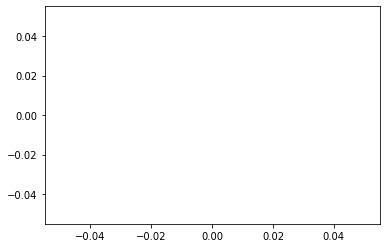

In [16]:
plt.plot(test_data_numbers_GN, TL_Raman_model_results_GN, label='GN-model', marker='x', color='g')
### add this is with the GGN model ###
plt.plot(test_data_numbers_GGN, TL_Raman_model_results_GGN, label='GGN-model', marker='o', color='b', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Training Data Size')
plt.legend()
plt.savefig(f'{data_path}/Figures/transfer_learning_Raman_results.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()